<a href="https://colab.research.google.com/github/vgkienzler/ai-engineering-notebooks/blob/main/OpenAI_API_Assistants_Stream_and_Events_Deep_Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up dependencies

In [1]:
# Install dependencies
# Make sure that you have OpenAI > 1.20 installed, or streaming will not work

!pip install -qU openai==1.33

In [2]:
import openai
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

openai.__version__

'1.33.0'

In [3]:
# Test that the OpenAI API Key works well after the recent updates, and that the
# newest model, 'gpt-4o', is accessible.
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Who won the world series in 2020?"},
    {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    {"role": "user", "content": "Where was it played?"}
  ]
)
print(response.choices[0].message.content)

The 2020 World Series was played at Globe Life Field in Arlington, Texas. This was part of the measures taken due to the COVID-19 pandemic, making it a neutral site for the entirety of the series.


# Streaming vs. Non-Streaming modes

### Non-Streaming

**File search** and **Function calling** tools can be run with or without streaming. This choice will have a significant impact on how to implement your assistant.

In **non-streaming mode**, the entire response is generated and returned as a single, complete output. This is the standard way many APIs work:
1. **Send request** - The query is sent to the OpenAI API for processing
2. **Wait while processing** - The API processes the input and generates the entire response
3. **Send the full response** - The entire response is sent back in one go.

This mode is the simplier to understand, and to implement, but leads to high latency which might adversly affect User Experience.

## `Run` stages

When not using streaming, you can check the status or stage of the running process (`run`) every now and then (by 'polling' the API), and wait until it terminates to collect the result.

When a run is initiated on OpenAI API, it will move through the following stages:

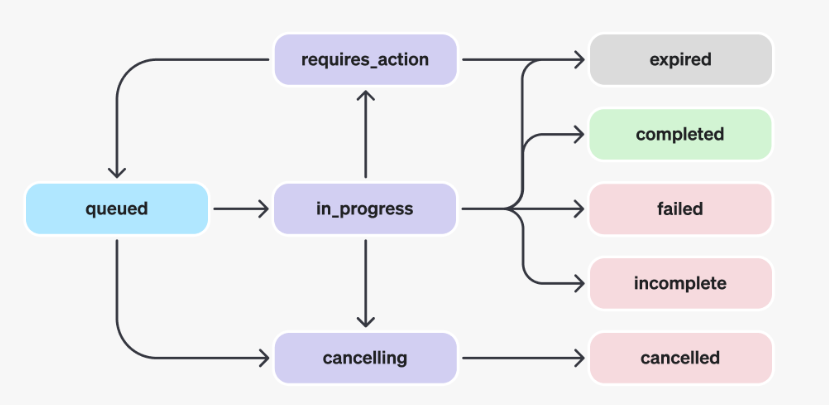

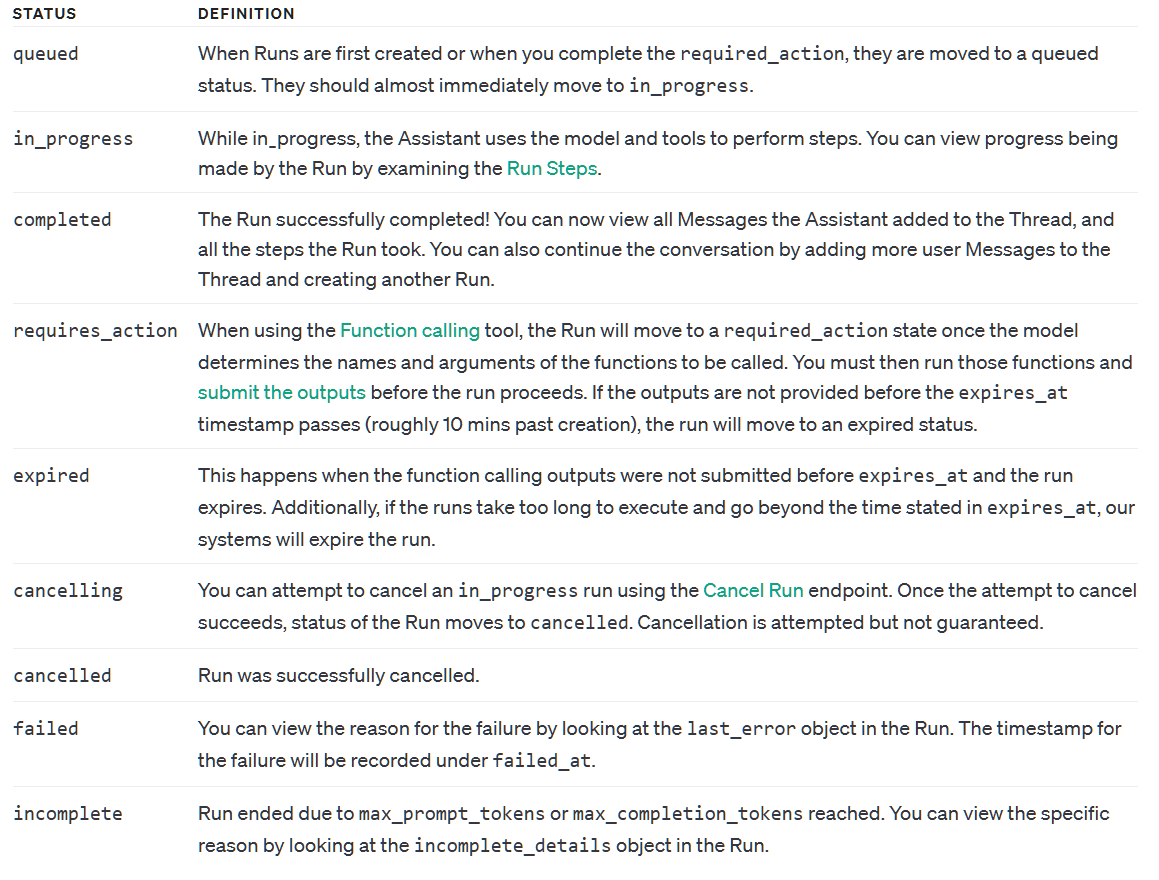

In order to 'poll' the API, and know what is the status of the run, there are two options:

1. Do it manually, using a `while` loop:
```
while run.status == "in_progress" or run.status == "queued":
      time.sleep(1)
      run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
      )
```
2. Use the built-in `runs.create_and_poll` method:
```
run = client.beta.threads.runs.create_and_poll(
      thread_id=thread.id,
      assistant_id=assistant.id,
)
```

Other `runs.<action>_and_poll` methods exist, such as `runs.submit_tool_outputs_and_poll`, which helps waiting for a run to finish processing.

## Streaming



In **streaming mode**, bits of the response are send back as soon as they are ready.
1. **Send request** - The query is sent to the OpenAI API for processing
2. **Processing and Streaming** - The API starts processing the input and sends it back in bits
3. **End of generation** - The stream ends when the last bit of information has been sent.

When file search or function calling are run **without streaming**, you just wait for the run to ends, then look at the resulting message(s) to get any information you need such as tool calls or message annotations.

However, if run **with streaming**, then you need *something* to tell you when the API starts sending chunks pertaining to the thread, to a message or to the run. Then you need to catch these `events` as they are sent and act on them, to either get the result of the file search or act on the call to run a tool.

The nature of these events depend on the API.




## Assistant Streaming Events

For OpenAI API, the list of the `Assistant Streaming Events` can be found on the [OpenAI API reference documentations](https://platform.openai.com/docs/api-reference/assistants-streaming/events).

Like for any beta version, documentation might not be up-to-date with the code base, so it's always a good idea to check in the code base (when available) what Assistant Streaming Events have been defined. For this, you can go to the [OpenAI GitHub repo](https://github.com/openai/openai-python/blob/main/src/openai/types/beta/assistant_stream_event.py) (copy below as of early June 2024).

It is a good habit to look at both the code and the documentation, since the code base is the source of truth.

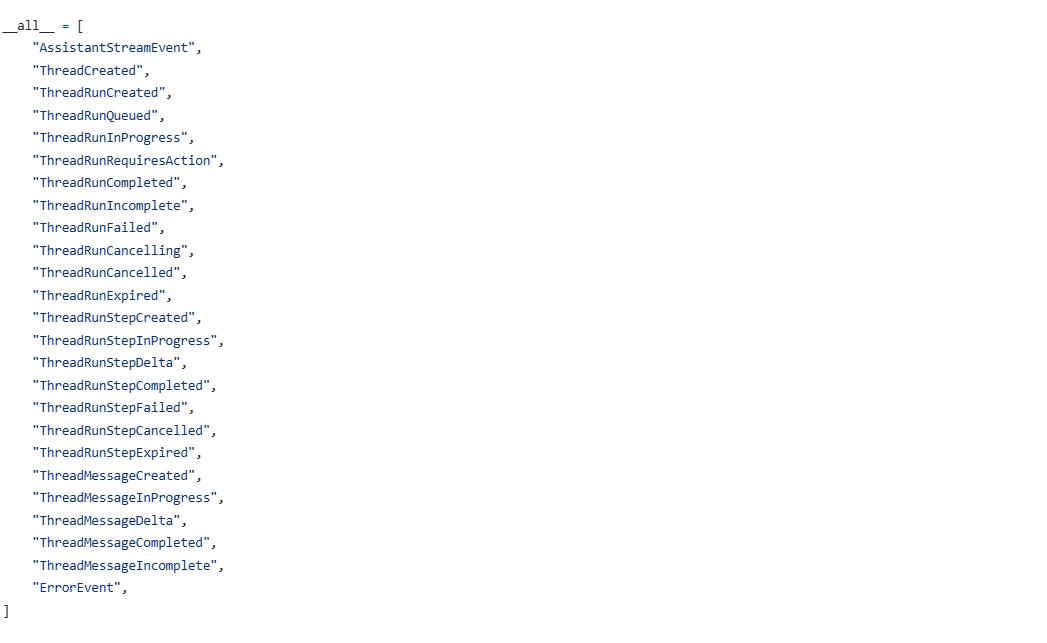

With this context in mind, let's look at both versions of Function Calling and File Search.

# Function Calling

## Without streaming

For this example, two tools (functions) are defined: one to get the current temperature, and another to get the probably of rain. The `description` attributes are particularly important, as they will serve as a basis for the model to chose what function to run.

In [4]:
get_current_temperature ={
    "type": "function",
    "function": {
      "name": "get_current_temperature",
      "description": "Get the current temperature for a specific location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {
            "type": "string",
            "description": "The city and state, e.g., San Francisco, CA"
          },
          "unit": {
            "type": "string",
            "enum": ["Celsius", "Fahrenheit"],
            "description": "The temperature unit to use. Infer this from the user's location."
          }
        },
        "required": ["location", "unit"]
      }
    }
  }

get_rain_probability = {
    "type": "function",
    "function": {
      "name": "get_rain_probability",
      "description": "Get the probability of rain for a specific location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {
            "type": "string",
            "description": "The city and state, e.g., San Francisco, CA"
          }
        },
        "required": ["location"]
      }
    }
  }

tools = [get_current_temperature, get_rain_probability]

Now, let's create the `assistant` and `thread`, and add a `message` to the `thread`:

In [5]:
from openai import OpenAI
client = OpenAI()

# Create an assistant with the 2 function tools aforementioned
assistant = client.beta.assistants.create(
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  model="gpt-4o",
  tools=tools
)

# Initate the thread
thread = client.beta.threads.create()

# Add a message to the thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="What's the weather in San Francisco today and the likelihood it'll rain?",
)

Then we create the `run` and poll the API until the `run` reaches a terminal status:

In [7]:
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=assistant.id,
)

if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
else:
  print(run.status)

requires_action


`requires_action` is the terminal status of the run. , and Run objects can have multiple statuses.

In the current situation, `requires_action` means that a tool call has been detected, and that further action needs to be taken to process these calls (see the life cycle of a `run` in the previous section). While the calls are processed, the `run` is paused and ready to resume as soon as the results from the tool calls are available. If no results are provided within about 10 mins, the `run` will be cancelled.

Now, the actions following the tool calls need to be defined. For this example, these actions consist in manually inputing temperature and rain probability.

In [8]:
print(run.required_action.submit_tool_outputs.tool_calls[0])
print(run.required_action.submit_tool_outputs.tool_calls[1])

RequiredActionFunctionToolCall(id='call_XLGYRi6xSGqRW6CsWcrw87Az', function=Function(arguments='{"location": "San Francisco, CA", "unit": "Fahrenheit"}', name='get_current_temperature'), type='function')
RequiredActionFunctionToolCall(id='call_NxRxI0pusgajT7HvhY3CESib', function=Function(arguments='{"location": "San Francisco, CA"}', name='get_rain_probability'), type='function')


In [9]:
# Define the list to store tool outputs
tool_outputs = []

# Loop through each tool in the required action section
# and create the tool outputs
for tool in run.required_action.submit_tool_outputs.tool_calls:
  if tool.function.name == "get_current_temperature":
    tool_outputs.append({
      "tool_call_id": tool.id,
      "output": "57"
    })
  elif tool.function.name == "get_rain_probability":
    tool_outputs.append({
      "tool_call_id": tool.id,
      "output": "0.06"
    })

# When a run generates tool calls, the run is paused and wait for the results of these tool
# calls to be sent back to it so that it can move to the next stages. For this, tool outputs must be submitted.
if tool_outputs:
  print(tool_outputs)
  try:
    run = client.beta.threads.runs.submit_tool_outputs_and_poll(
      thread_id=thread.id,
      run_id=run.id,
      tool_outputs=tool_outputs
    )
    print("Tool outputs submitted successfully.")
  except Exception as e:
    print("Failed to submit tool outputs:", e)
else:
  print("No tool outputs to submit.")

if run.status == 'completed':
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages)
else:
  print(run.status)

[{'tool_call_id': 'call_XLGYRi6xSGqRW6CsWcrw87Az', 'output': '57'}, {'tool_call_id': 'call_NxRxI0pusgajT7HvhY3CESib', 'output': '0.06'}]
Tool outputs submitted successfully.
SyncCursorPage[Message](data=[Message(id='msg_87SsYi9Q8XGYeu1OZh69OW1h', assistant_id='asst_aA9OtimSLzJgvipxpIys5I3r', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="Currently, it's 57°F in San Francisco, CA. The likelihood of rain today is 6%."), type='text')], created_at=1718109511, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_RCIx3bmf48lgM19daHNXdBi3', status=None, thread_id='thread_GTWfuTtOtK0Rui5eg2FJfVdr'), Message(id='msg_47UMPII3cPou7lEttE0UvWQv', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="What's the weather in San Francisco today and the likelihood it'll rain?"), type='text')], created_at=1718109507, incomplete_at=None, inco

The tool outputs have been successfully submitted back to the API, and the run has resumed with this new information. The final message can be generated, and the `run` is moved to `completed`.

## With streaming

Now let's test function calling with streaming.

This next part (assistant creation, thread creation, adding message to the thread) does not change, it's the same as without streaming.

In [10]:
# This bit does not change, it's the same as before
from openai import OpenAI
client = OpenAI()

assistant = client.beta.assistants.create(
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  model="gpt-4o",
  tools=tools
)

thread = client.beta.threads.create()

message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="What's the weather in San Francisco today and the likelihood it'll rain?",
)

However, creating the run is different, and an event handler is required. The last section of this notebook deep-dives into the `AssistantEventHandler` and how it works. In a nutshell, this handler is required to tell the assistant what to do when various events are triggered.

In [11]:
from typing_extensions import override
from openai import AssistantEventHandler

class FCEventHandler(AssistantEventHandler):
    @override
    def on_event(self, event):
      # Retrieve events that are denoted with 'requires_action'
      # since these will have our tool_calls
      if event.event == 'thread.run.requires_action':
        run_id = event.data.id  # Retrieve the run ID from the event data
        self.handle_requires_action(event.data, run_id)

    def handle_requires_action(self, data, run_id):
      tool_outputs = []

      for tool in data.required_action.submit_tool_outputs.tool_calls:
        print(tool.function.arguments)
        if tool.function.name == "get_current_temperature":
          tool_outputs.append({"tool_call_id": tool.id, "output": "57"})
        elif tool.function.name == "get_rain_probability":
          tool_outputs.append({"tool_call_id": tool.id, "output": "0.06"})

      # Submit all tool_outputs at the same time
      self.submit_tool_outputs(tool_outputs, run_id)

    def submit_tool_outputs(self, tool_outputs, run_id):
      # Use the submit_tool_outputs_stream helper
      with client.beta.threads.runs.submit_tool_outputs_stream(
        thread_id=self.current_run.thread_id,
        run_id=self.current_run.id,
        tool_outputs=tool_outputs,
        event_handler=FCEventHandler(),
      ) as stream:
        for text in stream.text_deltas:
          print(text, end="", flush=True)
        print()

In [12]:
# Now the run is streamed using a context manager (with ... pattern)
# toghether with the event handler defined previously
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  event_handler=FCEventHandler()
) as stream:
  stream.until_done()

{"location": "San Francisco, CA", "unit": "Fahrenheit"}
{"location": "San Francisco, CA"}
The current temperature in San Francisco, CA, is 57°F, and there's a 6% chance of rain today.


Please note that if you run several time the cell above, without creating a new thread or without adding a new message with a question, you won't see any result. This is because after the first run, the answer message is added to the thread, so there is no message with a pending question to answer.

### Tracking generated events

Now, let's look a bit closer at what events are emitted. For this, the `on_event()` method of the `AssistantEventHandler` is overriden to print the event type every time an event is appears.

In [13]:
class EventTrackerEventHandler(AssistantEventHandler):
    @override
    def on_event(self, event):
      # Print all the events which are emitted during a run
      print("New event: ", event.event)

# Execute the run with the new event handler
with client.beta.threads.runs.stream(
  thread_id=thread.id,
  assistant_id=assistant.id,
  event_handler=EventTrackerEventHandler()
) as stream:
  stream.until_done()

New event:  thread.run.created
New event:  thread.run.queued
New event:  thread.run.in_progress
New event:  thread.run.step.created
New event:  thread.run.step.in_progress
New event:  thread.message.created
New event:  thread.message.in_progress
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.delta
New event:  thread.message.d

### Why are Events needed, again?

**Streaming means that we will receive continuously bits of information (called delta)**, and we need to know what these delta are for, as well as when all the deltas for a run, message, or function call have been received.

To know all that, **Events** are required, as they signal to the user that the program will start streaming a specific object. Then, we streaming that object is finished, another event is sent to signal the user that everything has been sent.

Because of these Events, we need an **event handler **to define what should be done when an event is emitted.

In summary, to use streaming effectively, we need to:
1. **Know and understand what the different events are**
2. Know **what are the existing methods of the base event handler** `AssistantEventHandler`, so that we can 'override' (customize) them to our needs.

# The AssistantHandlerClass

As discussed previously, to understand streaming well it is important to understand what are the events generated by the OpenAI Assistant API (Assistant Stream Events), and how the `AssistantEventHandler` works.

The previous sections discussed what are Assistant Stream Events. This section dives on how the `AssistantEventHandler` works.

Once we know what are the Assistant Stream Events out there, we need to process them and act on them. For this, OpenAI API provides the AssistantEventHandler class. However, to be able to use this class efficiently, we need to know what method correspond to what event and what method you need to override.

Unfortunately, there is not API documentation for this class, so the only solution is to look at the code directly.

The code for the AssistantEventHandler class can be found [here on GitHub](https://github.com/openai/openai-python/blob/main/src/openai/lib/streaming/_assistants.py).

### Event handlers

The `AssistantEventHandler` comes with the following **event handlers**. As you can see, none of these are defined (do anything). They are just empty shell, here to unify method name.

So, if you want something to happen you need to re-define these, using the `@override` decorator.
```
   # event handlers

    def on_end(self) -> None:
        """Fires when the stream has finished.

        This happens if the stream is read to completion
        or if an exception occurs during iteration.
        """

    def on_event(self, event: AssistantStreamEvent) -> None:
        """Callback that is fired for every Server-Sent-Event"""

    def on_run_step_created(self, run_step: RunStep) -> None:
        """Callback that is fired when a run step is created"""

    def on_run_step_delta(self, delta: RunStepDelta, snapshot: RunStep) -> None:
        """Callback that is fired whenever a run step delta is returned from the API

        The first argument is just the delta as sent by the API and the second argument
        is the accumulated snapshot of the run step. For example, a tool calls event may
        look like this:

        # delta
        tool_calls=[
            RunStepDeltaToolCallsCodeInterpreter(
                index=0,
                type='code_interpreter',
                id=None,
                code_interpreter=CodeInterpreter(input=' sympy', outputs=None)
            )
        ]
        # snapshot
        tool_calls=[
            CodeToolCall(
                id='call_wKayJlcYV12NiadiZuJXxcfx',
                code_interpreter=CodeInterpreter(input='from sympy', outputs=[]),
                type='code_interpreter',
                index=0
            )
        ],
        """

    def on_run_step_done(self, run_step: RunStep) -> None:
        """Callback that is fired when a run step is completed"""

    def on_tool_call_created(self, tool_call: ToolCall) -> None:
        """Callback that is fired when a tool call is created"""

    def on_tool_call_delta(self, delta: ToolCallDelta, snapshot: ToolCall) -> None:
        """Callback that is fired when a tool call delta is encountered"""

    def on_tool_call_done(self, tool_call: ToolCall) -> None:
        """Callback that is fired when a tool call delta is encountered"""

    def on_exception(self, exception: Exception) -> None:
        """Fired whenever an exception happens during streaming"""

    def on_timeout(self) -> None:
        """Fires if the request times out"""

    def on_message_created(self, message: Message) -> None:
        """Callback that is fired when a message is created"""

    def on_message_delta(self, delta: MessageDelta, snapshot: Message) -> None:
        """Callback that is fired whenever a message delta is returned from the API

        The first argument is just the delta as sent by the API and the second argument
        is the accumulated snapshot of the message. For example, a text content event may
        look like this:

        # delta
        MessageDeltaText(
            index=0,
            type='text',
            text=Text(
                value=' Jane'
            ),
        )
        # snapshot
        MessageContentText(
            index=0,
            type='text',
            text=Text(
                value='Certainly, Jane'
            ),
        )
        """

    def on_message_done(self, message: Message) -> None:
        """Callback that is fired when a message is completed"""

    def on_text_created(self, text: Text) -> None:
        """Callback that is fired when a text content block is created"""

    def on_text_delta(self, delta: TextDelta, snapshot: Text) -> None:
        """Callback that is fired whenever a text content delta is returned
        by the API.

        The first argument is just the delta as sent by the API and the second argument
        is the accumulated snapshot of the text. For example:

        on_text_delta(TextDelta(value="The"), Text(value="The")),
        on_text_delta(TextDelta(value=" solution"), Text(value="The solution")),
        on_text_delta(TextDelta(value=" to"), Text(value="The solution to")),
        on_text_delta(TextDelta(value=" the"), Text(value="The solution to the")),
        on_text_delta(TextDelta(value=" equation"), Text(value="The solution to the equivalent")),
        """

    def on_text_done(self, text: Text) -> None:
        """Callback that is fired when a text content block is finished"""

    def on_image_file_done(self, image_file: ImageFile) -> None:
        """Callback that is fired when an image file block is finished"""
```





### When are these events triggered?

Now, knowing what even handlers exist is great, but understanding when they are triggered is even more important.

If we want to dig deeper and understand on what condition(s) these various event handlers are triggered, we need to dive into the code as there is currently no documentation supporting it.

For instance, the methods `on_tool_call_created`, `on_tool_call_delta`, and `on_tool_call_done` do not correspond to clearly defined stream events. To understand what they correspond to would require looking at the code.

    def _emit_sse_event(self, event: AssistantStreamEvent) -> None:
        self._current_event = event
        self.on_event(event)

        self.__current_message_snapshot, new_content = accumulate_event(
            event=event,
            current_message_snapshot=self.__current_message_snapshot,
        )
        if self.__current_message_snapshot is not None:
            self.__message_snapshots[self.__current_message_snapshot.id] = self.__current_message_snapshot

        accumulate_run_step(
            event=event,
            run_step_snapshots=self.__run_step_snapshots,
        )

        for content_delta in new_content:
            assert self.__current_message_snapshot is not None

            block = self.__current_message_snapshot.content[content_delta.index]
            if block.type == "text":
                self.on_text_created(block.text)

        if (
            event.event == "thread.run.completed"
            or event.event == "thread.run.cancelled"
            or event.event == "thread.run.expired"
            or event.event == "thread.run.failed"
            or event.event == "thread.run.requires_action"
            or event.event == "thread.run.incomplete"
        ):
            self.__current_run = event.data
            if self._current_tool_call:
                self.on_tool_call_done(self._current_tool_call)
        elif (
            event.event == "thread.run.created"
            or event.event == "thread.run.in_progress"
            or event.event == "thread.run.cancelling"
            or event.event == "thread.run.queued"
        ):
            self.__current_run = event.data
        elif event.event == "thread.message.created":
            self.on_message_created(event.data)
        elif event.event == "thread.message.delta":
            snapshot = self.__current_message_snapshot
            assert snapshot is not None

            message_delta = event.data.delta
            if message_delta.content is not None:
                for content_delta in message_delta.content:
                    if content_delta.type == "text" and content_delta.text:
                        snapshot_content = snapshot.content[content_delta.index]
                        assert snapshot_content.type == "text"
                        self.on_text_delta(content_delta.text, snapshot_content.text)

                    # If the delta is for a new message content:
                    # - emit on_text_done/on_image_file_done for the previous message content
                    # - emit on_text_created/on_image_created for the new message content
                    if content_delta.index != self._current_message_content_index:
                        if self._current_message_content is not None:
                            if self._current_message_content.type == "text":
                                self.on_text_done(self._current_message_content.text)
                            elif self._current_message_content.type == "image_file":
                                self.on_image_file_done(self._current_message_content.image_file)

                        self._current_message_content_index = content_delta.index
                        self._current_message_content = snapshot.content[content_delta.index]

                    # Update the current_message_content (delta event is correctly emitted already)
                    self._current_message_content = snapshot.content[content_delta.index]

            self.on_message_delta(event.data.delta, snapshot)
        elif event.event == "thread.message.completed" or event.event == "thread.message.incomplete":
            self.__current_message_snapshot = event.data
            self.__message_snapshots[event.data.id] = event.data

            if self._current_message_content_index is not None:
                content = event.data.content[self._current_message_content_index]
                if content.type == "text":
                    self.on_text_done(content.text)
                elif content.type == "image_file":
                    self.on_image_file_done(content.image_file)

            self.on_message_done(event.data)
        elif event.event == "thread.run.step.created":
            self.__current_run_step_id = event.data.id
            self.on_run_step_created(event.data)
        elif event.event == "thread.run.step.in_progress":
            self.__current_run_step_id = event.data.id
        elif event.event == "thread.run.step.delta":
            step_snapshot = self.__run_step_snapshots[event.data.id]

            run_step_delta = event.data.delta
            if (
                run_step_delta.step_details
                and run_step_delta.step_details.type == "tool_calls"
                and run_step_delta.step_details.tool_calls is not None
            ):
                assert step_snapshot.step_details.type == "tool_calls"
                for tool_call_delta in run_step_delta.step_details.tool_calls:
                    if tool_call_delta.index == self._current_tool_call_index:
                        self.on_tool_call_delta(
                            tool_call_delta,
                            step_snapshot.step_details.tool_calls[tool_call_delta.index],
                        )

                    # If the delta is for a new tool call:
                    # - emit on_tool_call_done for the previous tool_call
                    # - emit on_tool_call_created for the new tool_call
                    if tool_call_delta.index != self._current_tool_call_index:
                        if self._current_tool_call is not None:
                            self.on_tool_call_done(self._current_tool_call)

                        self._current_tool_call_index = tool_call_delta.index
                        self._current_tool_call = step_snapshot.step_details.tool_calls[tool_call_delta.index]
                        self.on_tool_call_created(self._current_tool_call)

                    # Update the current_tool_call (delta event is correctly emitted already)
                    self._current_tool_call = step_snapshot.step_details.tool_calls[tool_call_delta.index]

            self.on_run_step_delta(
                event.data.delta,
                step_snapshot,
            )
        elif (
            event.event == "thread.run.step.completed"
            or event.event == "thread.run.step.cancelled"
            or event.event == "thread.run.step.expired"
            or event.event == "thread.run.step.failed"
        ):
            if self._current_tool_call:
                self.on_tool_call_done(self._current_tool_call)

            self.on_run_step_done(event.data)
            self.__current_run_step_id = None
        elif event.event == "thread.created" or event.event == "thread.message.in_progress" or event.event == "error":
            # currently no special handling
            ...
        else:
            # we only want to error at build-time
            if TYPE_CHECKING:  # type: ignore[unreachable]
                assert_never(event)

        self._current_event = None

# File Search

The `file_search` is pretty powerful as it emplements straight out of the box keyword and semantic search, reranking and rewrite user's query to optimize them for search.

>The `file_search` tool implements several retrieval best practices out of the box to help you extract the right data from your files and augment the model’s responses. The `file_search` tool:
>
>* Rewrites user queries to optimize them for search.
* Breaks down complex user queries into multiple searches it can run in parallel.
* Runs both keyword and semantic searches across both assistant and thread vector stores.
* Reranks search results to pick the most relevant ones before generating the final response.
>
>By default, the `file_search` tool uses the following settings but these can be configured to suit your needs:
>
>* Chunk size: 800 tokens
* Chunk overlap: 400 tokens
* Embedding model: text-embedding-3-large at 256 dimensions
* Maximum number of chunks added to context: 20 (could be fewer)

## Without streaming

This example is taken from the main class, with nothing new except some additional, useful, details.

In [14]:
!wget https://github.com/dbredvick/paul-graham-to-kindle/blob/main/paul_graham_essays.txt

--2024-06-11 12:38:40--  https://github.com/dbredvick/paul-graham-to-kindle/blob/main/paul_graham_essays.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘paul_graham_essays.txt.1’

paul_graham_essays.     [ <=>                ] 266.67K  --.-KB/s    in 0.05s   

2024-06-11 12:38:41 (5.00 MB/s) - ‘paul_graham_essays.txt.1’ saved [273068]



In [15]:
vector_store = client.beta.vector_stores.create(name="Paul Graham Essay Compilation")
vector_store.id

'vs_ALos5YdpjwnzVcO3nncsEMxi'

Vector store can then be added to either a `Thread` or an `Assistant`. Each `vector_store` can contain up to 10,000 files. The maximum file size is 512MB and should not contain 5 million tokens per file. The list of supported files is available [here](https://platform.openai.com/docs/assistants/tools/file-search/supported-files).

Once a vector store is created, files can be processed and added to it.

If you want to customize the size of the chunks, as well as the overlap between chunks, you can do that via the `chunking_strategy` parameter (see below).

In [16]:
file_paths = ["paul_graham_essays.txt"]
file_streams = [open(path, "rb") for path in file_paths]

file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id,
  files=file_streams,
  # This 'chunking_strategy' parameter allows to specify max_chunk_size_tokens and chunk_overlap_tokens.
  chunking_strategy={"type": "static", "static": {"max_chunk_size_tokens": 800, "chunk_overlap_tokens": 400}}
)

# Checking the status and number of file processed to make sure that everything went well
print("file_batch status: ", file_batch.status)
print("Number of files processed: ", file_batch.file_counts)

file_batch status:  completed
Number of files processed:  FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)


In [17]:
# Create the assistant and allows it to use the vector stores attached to answer
# the user's query.
fs_assistant = client.beta.assistants.create(
  name="assistant_with_file_search",
  instructions="You are a helpful assistant",
  model="gpt-4-turbo",
  tools=[{"type": "file_search"}],
)

# Add the vector_store to the assistant.
# vector stores can be added either to the assistant or to the thread.
fs_assistant = client.beta.assistants.update(
  assistant_id=fs_assistant.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)

# Check if the assistant has the right resources
print(fs_assistant.tool_resources)

ToolResources(code_interpreter=None, file_search=ToolResourcesFileSearch(vector_store_ids=['vs_ALos5YdpjwnzVcO3nncsEMxi']))


In [18]:
# Create the thread.
# Here the vector store is again attached to the thread, which is unecessary.
fs_thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "What did Paul Graham say about Silicon Valley?",
    }],
  # Unnecessary since already attached to the assistant. Put here as an example.
  tool_resources={
    "file_search": {"vector_store_ids": [vector_store.id]}
  }
)

# The thread now has a vector store with a file in its tool resources.
messages = client.beta.threads.messages.list(
  thread_id=fs_thread.id
)

# Check the messages as well as the resources available
print(messages)
print(fs_thread.tool_resources)

SyncCursorPage[Message](data=[Message(id='msg_KxOV6ZorjvUQbTNvk9qbg2k6', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='What did Paul Graham say about Silicon Valley?'), type='text')], created_at=1718109526, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='user', run_id=None, status=None, thread_id='thread_Cr12ycsOR9Mci9HN9wnmjMTg')], object='list', first_id='msg_KxOV6ZorjvUQbTNvk9qbg2k6', last_id='msg_KxOV6ZorjvUQbTNvk9qbg2k6', has_more=False)
ToolResources(code_interpreter=None, file_search=ToolResourcesFileSearch(vector_store_ids=['vs_ALos5YdpjwnzVcO3nncsEMxi']))


`Threads` and `assistants` are similar, whether using streaming or not.

However, when not using streaming, `runs` are created differently. When not using streaming, the `runs.create_and_poll` method is used, as opposed to the `runs.stream` method.

In [19]:
# Use the create and poll SDK helper to create a run and poll the status of
# the run until it's in a terminal state.

fs_run = client.beta.threads.runs.create_and_poll(
    thread_id=fs_thread.id,
    assistant_id=fs_assistant.id
)

print(fs_run.status)

completed


In [20]:
messages = list(client.beta.threads.messages.list(
  thread_id=fs_thread.id,
  run_id=fs_run.id,
))

print(messages)

message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

[Message(id='msg_ZO2hJP81v70NCEPA1MKAXwz0', assistant_id='asst_EypRVXabSPxoDVER4WKAHk3x', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value="Paul Graham discusses Silicon Valley's role as a hub for technology and startups, noting that it provides an optimal environment for the birth and growth of new technologies and businesses. Graham details the unique ecosystem of Silicon Valley, which combines a dense concentration of tech talent, venture capital, and collaborative opportunities that support innovation and entrepreneurship. He suggests that the presence of established tech giants alongside emerging startups creates a fertile ground for networking and the exchange of ideas, which is essential for technological progress and business success ."), type='text')], created_at=1718109534, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_3KAHgd8ntI0VQTIpxPADJX5T', status=None, thread_i

## With streaming

In [21]:
# This bit does not change, it's the same as before
from openai import OpenAI
client = OpenAI()

fs_assistant = client.beta.assistants.create(
  name="assistant_with_file_search",
  instructions="You are a helpful assistant",
  model="gpt-4o",
  tools=[
      {
          "type": "file_search",
          "file_search": {"max_num_results": 10},
      }
    ],
)

fs_thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "What did Paul Graham say about Silicon Valley?",
    }],
  tool_resources={
    "file_search": {"vector_store_ids": [vector_store.id]},
  },
)

print(fs_thread.tool_resources)

ToolResources(code_interpreter=None, file_search=ToolResourcesFileSearch(vector_store_ids=['vs_ALos5YdpjwnzVcO3nncsEMxi']))


In [22]:
from typing_extensions import override
from openai import AssistantEventHandler, OpenAI

class FSEventHandler(AssistantEventHandler):
    @override
    def on_text_created(self, text) -> None:
        print(f"\nassistant > ", end="", flush=True)

    @override
    def on_tool_call_created(self, tool_call):
        print(f"\nassistant > {tool_call.type}\n", flush=True)

    @override
    def on_message_done(self, message) -> None:
        # print a citation to the file searched
        message_content = message.content[0].text
        annotations = message_content.annotations
        citations = []
        for index, annotation in enumerate(annotations):
            message_content.value = message_content.value.replace(
                annotation.text, f"[{index}]"
            )
            if file_citation := getattr(annotation, "file_citation", None):
                cited_file = client.files.retrieve(file_citation.file_id)
                citations.append(f"[{index}] {cited_file.filename}")

        print(message_content.value)
        print("\n".join(citations))

In [23]:
# Then, we use the stream SDK helper
# with the EventHandler class to create the Run
# and stream the response.

with client.beta.threads.runs.stream(
    thread_id=fs_thread.id,
    assistant_id=fs_assistant.id,
    event_handler=FSEventHandler(),
) as stream:
    stream.until_done()


assistant > file_search


assistant > In his essays, Paul Graham discusses Silicon Valley extensively. Here are some key points he makes:

1. **Center of Innovation**: Silicon Valley is depicted as a hub of innovation, where ideas flourish and transform into successful enterprises. Graham highlights the concentration of ambitious and talented individuals as a significant factor driving this innovation.

2. **Culture and Ethos**: The culture in Silicon Valley is characterized by a strong work ethic, risk-taking, and a willingness to embrace failure as part of the learning process. This mindset is what allows startups and technology companies to push boundaries and create groundbreaking products.

3. **Supportive Ecosystem**: The region's ecosystem, including access to venture capital, mentorship, and a community of like-minded entrepreneurs, is essential in nurturing startups and helping them grow.

4. **Importance of Execution**: While ideas are crucial, execution is paramount. In Sil